<a href="https://colab.research.google.com/github/trick491/Data-Science-Final-Project/blob/main/milestone1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring the Relationship Between Financial Statement Items and Stock Performance**

Patrick Johnson and Anh Pham

##**Project Goals**

The goal of this project is to analyze and determine how different financial statement indexes correlate with stock price changes for companies in the S&P 500 over the past ten years. Instead of focusing on the most common measure, earnings per share (EPS), we want to see if factors like depreciation, assets, or liabilities also help explain stock performance. By finding these correlations, we hope to better understand how financial decisions and company internal set up are reflected in investor behavior and market value.
<br><br>

##**Project Dataset**

The datasets we are considering working with are the SEC EDGAR Financial Statement Metrics and Yahoo Finance Historical Stock Data. Together, these two datasets will allow us to examine how companies’ internal financial structures influence their external market performance over time. Our goal is to identify relationships between balance sheet and income statement items, especially those unrelated to earnings per share (EPS) (such as depreciation and total liabilities), and stock price trends for firms in the S&P 500 index.
<br><br>
The SEC EDGAR dataset provides standardized financial statement information of publicly traded U.S. companies, including variables like total assets, total liabilities, depreciation, and operating income. The Yahoo Finance dataset contains corresponding market data such as daily closing prices and trading volumes. By organizing the stock data by year and linking it to the financial data from EDGAR using company tickers or IDs, we can create one dataset that shows both a company’s financial performance and its market value
<br><br>
This integration will allow us to answer questions such as: How do changes in liabilities or depreciation expenses relate to changes in stock prices? Do firms with more asset growth correlate to higher long-term stock performance? Combining these two datasets bridges the gap between corporate accounting and investor behavior, providing a comprehensive foundation for analyzing how internal financial indicators translate into market outcomes.
<br><br>

##**Collaboration Plan**
Our collaboration plan is to divide tasks and work individually on google colab, while actively communicating via message. We will meet up in person once a week to update our progress, finalize our project vision, discuss the quality of our work, and resolve any issues. We have also set up a shared GitHub repository to coordinate our work and upload code. All code contributions are documented with clear comments and commit messages. One member will focus on data extraction and cleaning (ETL from EDGAR and Yahoo Finance). The other will handle data analysis and visualization, ensuring results are clearly communicated on our GitHub Pages website. We will focus on our task but also actively assist the other person when needed.  



**Pull Together Data**

In [13]:
import pandas as pd
import requests

# EDGAR API for Apple Inc.
cik = "0001652044"
edgar_api = f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json'

# SEC requires proper User-Agent header
headers = {
    'User-Agent': 'Your Company Name your.email@domain.com',
    'Accept-Encoding': 'gzip, deflate'
}

# Fetch EDGAR data
edgar_response = requests.get(edgar_api, headers=headers)
edgar_df = pd.DataFrame()

if edgar_response.status_code == 200:
    data = edgar_response.json()

    # Extract all US-GAAP data
    us_gaap_data = []

    if 'us-gaap' in data.get('facts', {}):
        for fact_name, fact_details in data['facts']['us-gaap'].items():
            if 'units' in fact_details:
                for unit_type, records in fact_details['units'].items():
                    for record in records:
                        us_gaap_data.append({
                            'fact_name': fact_name,
                            'label': fact_details.get('label', ''),
                            'description': fact_details.get('description', ''),
                            'unit': unit_type,
                            'value': record.get('val'),
                            'start_date': record.get('start'),
                            'end_date': record.get('end'),
                            'filed_date': record.get('filed'),
                            'form': record.get('form'),
                            'frame': record.get('frame', ''),
                            'fiscal_year': record.get('fy'),
                            'fiscal_period': record.get('fp'),
                            'accn': record.get('accn'),
                            'company_cik': data.get('cik'),
                            'company_name': data.get('entityName')
                        })

    edgar_df = pd.DataFrame(us_gaap_data)

# Yahoo API (your existing code)
yahoo_api = 'https://api.github.com/repos/trick491/Data-Science-Final-Project/contents/data/yahoo'
yahoo_response = requests.get(yahoo_api)
yahoo_df = pd.DataFrame()

if yahoo_response.status_code == 200:
    yahoo_files = yahoo_response.json()
    for file in yahoo_files:
        if file['name'].endswith('.csv'):
            file_url = file['download_url']
            df_temp = pd.read_csv(file_url)
            yahoo_df = pd.concat([yahoo_df, df_temp], ignore_index=True)
            print(f"Loaded Yahoo file: {file['name']}")

print(f"EDGAR DataFrame shape: {edgar_df.shape}")
print(f"Yahoo DataFrame shape: {yahoo_df.shape}")

# Display first few rows of EDGAR data with label and description
print("\nEDGAR US-GAAP Data Sample:")
edgar_df['Ticker'] = 'GOOG'
print(edgar_df.head())



Loaded Yahoo file: yahoo_1.csv
Loaded Yahoo file: yahoo_10.csv
Loaded Yahoo file: yahoo_11.csv
Loaded Yahoo file: yahoo_12.csv
Loaded Yahoo file: yahoo_13.csv
Loaded Yahoo file: yahoo_14.csv
Loaded Yahoo file: yahoo_15.csv
Loaded Yahoo file: yahoo_16.csv
Loaded Yahoo file: yahoo_17.csv
Loaded Yahoo file: yahoo_18.csv
Loaded Yahoo file: yahoo_19.csv
Loaded Yahoo file: yahoo_2.csv
Loaded Yahoo file: yahoo_20.csv
Loaded Yahoo file: yahoo_21.csv
Loaded Yahoo file: yahoo_22.csv
Loaded Yahoo file: yahoo_23.csv
Loaded Yahoo file: yahoo_24.csv
Loaded Yahoo file: yahoo_25.csv
Loaded Yahoo file: yahoo_26.csv
Loaded Yahoo file: yahoo_27.csv
Loaded Yahoo file: yahoo_28.csv
Loaded Yahoo file: yahoo_29.csv
Loaded Yahoo file: yahoo_3.csv
Loaded Yahoo file: yahoo_30.csv
Loaded Yahoo file: yahoo_31.csv
Loaded Yahoo file: yahoo_32.csv
Loaded Yahoo file: yahoo_33.csv
Loaded Yahoo file: yahoo_34.csv
Loaded Yahoo file: yahoo_35.csv
Loaded Yahoo file: yahoo_36.csv
Loaded Yahoo file: yahoo_37.csv
Loaded Yaho

Now we will create two rows with price before and after quarterlies with percent and $ change of prices

In [19]:
from multiprocessing import Pool, cpu_count
import numpy as np
from tqdm import tqdm

# FILTER BY TICKER: Set to None for all stocks, or specify ticker like 'GOOG'
FILTER_TICKER = 'GOOG'  # Default: process all tickers. Change to 'GOOG', 'AAPL', etc. to isolate one stock

print(edgar_df.head())
print(yahoo_df.head())

# Filter data if ticker is specified BEFORE copying
if FILTER_TICKER is not None:
    print(f"\n*** FILTERING DATA FOR TICKER: {FILTER_TICKER} ***\n")
    full_data = edgar_df[edgar_df['Ticker'] == FILTER_TICKER].copy()
    yahoo_df_filtered = yahoo_df[yahoo_df['Ticker'] == FILTER_TICKER].copy()
    print(f"Filtered to {len(full_data)} edgar rows and {len(yahoo_df_filtered)} yahoo rows for {FILTER_TICKER}")
else:
    print(f"\n*** PROCESSING ALL TICKERS ***\n")
    full_data = edgar_df.copy()
    yahoo_df_filtered = yahoo_df.copy()
    print(f"Total edgar rows: {len(full_data)}, Total yahoo rows: {len(yahoo_df_filtered)}")

# Create a dictionary for faster lookups (only for filtered tickers)
print("Creating lookup dictionary...")
yahoo_dict = {}
for ticker in tqdm(yahoo_df_filtered['Ticker'].unique(), desc="Processing tickers"):
    ticker_data = yahoo_df_filtered[yahoo_df_filtered['Ticker'] == ticker].sort_values('Date')
    yahoo_dict[ticker] = ticker_data

def get_price_before(args):
    idx, ticker, end_date = args

    if ticker not in yahoo_dict:
        return None

    ticker_data = yahoo_dict[ticker]
    matching = ticker_data[ticker_data['Date'] <= end_date]
    return matching.iloc[-1]['Close'] if len(matching) > 0 else None

def get_price_after(args):
    idx, ticker, end_date = args

    if ticker not in yahoo_dict:
        return None

    ticker_data = yahoo_dict[ticker]
    matching = ticker_data[ticker_data['Date'] > end_date]
    return matching.iloc[0]['Close'] if len(matching) > 0 else None

# Prepare arguments for parallel processing
print("Preparing data...")
args_list = [(idx, row.Ticker, row.end_date) for idx, row in enumerate(full_data.itertuples())]

# Calculate Price before in parallel
num_cores = cpu_count()
print(f"\nUsing {num_cores} cores")
print("Calculating 'Price before' in parallel...")

with Pool(num_cores) as pool:
    results = list(tqdm(
        pool.imap(get_price_before, args_list, chunksize=1000),
        total=len(args_list),
        desc="Price before"
    ))
    full_data['Price before'] = results

print("✓ 'Price before' complete!\n")

# Calculate Price after in parallel
print("Calculating 'Price after' in parallel...")

with Pool(num_cores) as pool:
    results = list(tqdm(
        pool.imap(get_price_after, args_list, chunksize=1000),
        total=len(args_list),
        desc="Price after"
    ))
    full_data['Price after'] = results

print("✓ 'Price after' complete!\n")

print('****************** AFTER TRANSFORMATION ********************')
full_data['value'] = full_data['value'].astype(float)
full_data['Price after % change'] = ((full_data['Price after'] / full_data['Price before']) - 1) * 100
full_data['Price after $ change'] = full_data['Price after'] - full_data['Price before']
print(full_data.head())

                fact_name                      label  \
0  AccountsPayableCurrent  Accounts Payable, Current   
1  AccountsPayableCurrent  Accounts Payable, Current   
2  AccountsPayableCurrent  Accounts Payable, Current   
3  AccountsPayableCurrent  Accounts Payable, Current   
4  AccountsPayableCurrent  Accounts Payable, Current   

                                         description unit         value  \
0  Carrying value as of the balance sheet date of...  USD  1.715000e+09   
1  Carrying value as of the balance sheet date of...  USD  1.715000e+09   
2  Carrying value as of the balance sheet date of...  USD  1.715000e+09   
3  Carrying value as of the balance sheet date of...  USD  1.549000e+09   
4  Carrying value as of the balance sheet date of...  USD  1.931000e+09   

  start_date    end_date  filed_date  form      frame  fiscal_year  \
0       None  2014-12-31  2015-10-29  10-Q                    2015   
1       None  2014-12-31  2016-02-11  10-K                    2015   
2 

Processing tickers: 100%|██████████| 1/1 [00:00<00:00, 198.63it/s]

Preparing data...

Using 2 cores
Calculating 'Price before' in parallel...



Price before: 100%|██████████| 18637/18637 [00:17<00:00, 1077.21it/s]

✓ 'Price before' complete!

Calculating 'Price after' in parallel...



Price after: 100%|██████████| 18637/18637 [00:15<00:00, 1219.61it/s]

✓ 'Price after' complete!

****************** AFTER TRANSFORMATION ********************
                fact_name                      label  \
0  AccountsPayableCurrent  Accounts Payable, Current   
1  AccountsPayableCurrent  Accounts Payable, Current   
2  AccountsPayableCurrent  Accounts Payable, Current   
3  AccountsPayableCurrent  Accounts Payable, Current   
4  AccountsPayableCurrent  Accounts Payable, Current   

                                         description unit         value  \
0  Carrying value as of the balance sheet date of...  USD  1.715000e+09   
1  Carrying value as of the balance sheet date of...  USD  1.715000e+09   
2  Carrying value as of the balance sheet date of...  USD  1.715000e+09   
3  Carrying value as of the balance sheet date of...  USD  1.549000e+09   
4  Carrying value as of the balance sheet date of...  USD  1.931000e+09   

  start_date    end_date  filed_date  form      frame  fiscal_year  \
0       None  2014-12-31  2015-10-29  10-Q            

Example of balance sheet item (snapshot) treatment in EDGAR - end_date only

change of values is treated normally on end_date from last end date

In [26]:
import pandas as pd
import numpy as np

example = full_data.copy()

# Display the subset of data for 'Accounts Payable, Current'
example = example.loc[example['label'] == 'Accounts Payable, Current'][['Ticker','fact_name', 'label', 'description', 'value', 'start_date',
   'end_date', 'filed_date', 'form', 'frame', 'Price before',
   'Price after', 'Price after $ change', 'Price after % change']]

# Calculate 'value before' (previous period's value)
# Assuming the data is sorted by date, use shift(1) to get the previous value
example['value before'] = example.groupby('fact_name')['value'].shift(1)

# Calculate 'value $ change' (current value - previous value)
example['value $ change'] = example['value'] - example['value before']

# Calculate 'value % before' (percentage change from previous value)
# Formula: ((current value - previous value) / previous value) * 100
example['value % before'] = (example['value $ change'] / example['value before'].replace(0, np.nan)) * 100

print(example.head(20))








   Ticker               fact_name                      label  \
0    GOOG  AccountsPayableCurrent  Accounts Payable, Current   
1    GOOG  AccountsPayableCurrent  Accounts Payable, Current   
2    GOOG  AccountsPayableCurrent  Accounts Payable, Current   
3    GOOG  AccountsPayableCurrent  Accounts Payable, Current   
4    GOOG  AccountsPayableCurrent  Accounts Payable, Current   
5    GOOG  AccountsPayableCurrent  Accounts Payable, Current   
6    GOOG  AccountsPayableCurrent  Accounts Payable, Current   
7    GOOG  AccountsPayableCurrent  Accounts Payable, Current   
8    GOOG  AccountsPayableCurrent  Accounts Payable, Current   
9    GOOG  AccountsPayableCurrent  Accounts Payable, Current   
10   GOOG  AccountsPayableCurrent  Accounts Payable, Current   
11   GOOG  AccountsPayableCurrent  Accounts Payable, Current   
12   GOOG  AccountsPayableCurrent  Accounts Payable, Current   
13   GOOG  AccountsPayableCurrent  Accounts Payable, Current   
14   GOOG  AccountsPayableCurrent  Accou

Add percent change of values from previous - in this case A

Example of relation, normalized, between Accounts Payable and price before and after for Google

['Accounts Payable, Current']

Correlation between value % before and Price after % change for GOOG: -0.2470


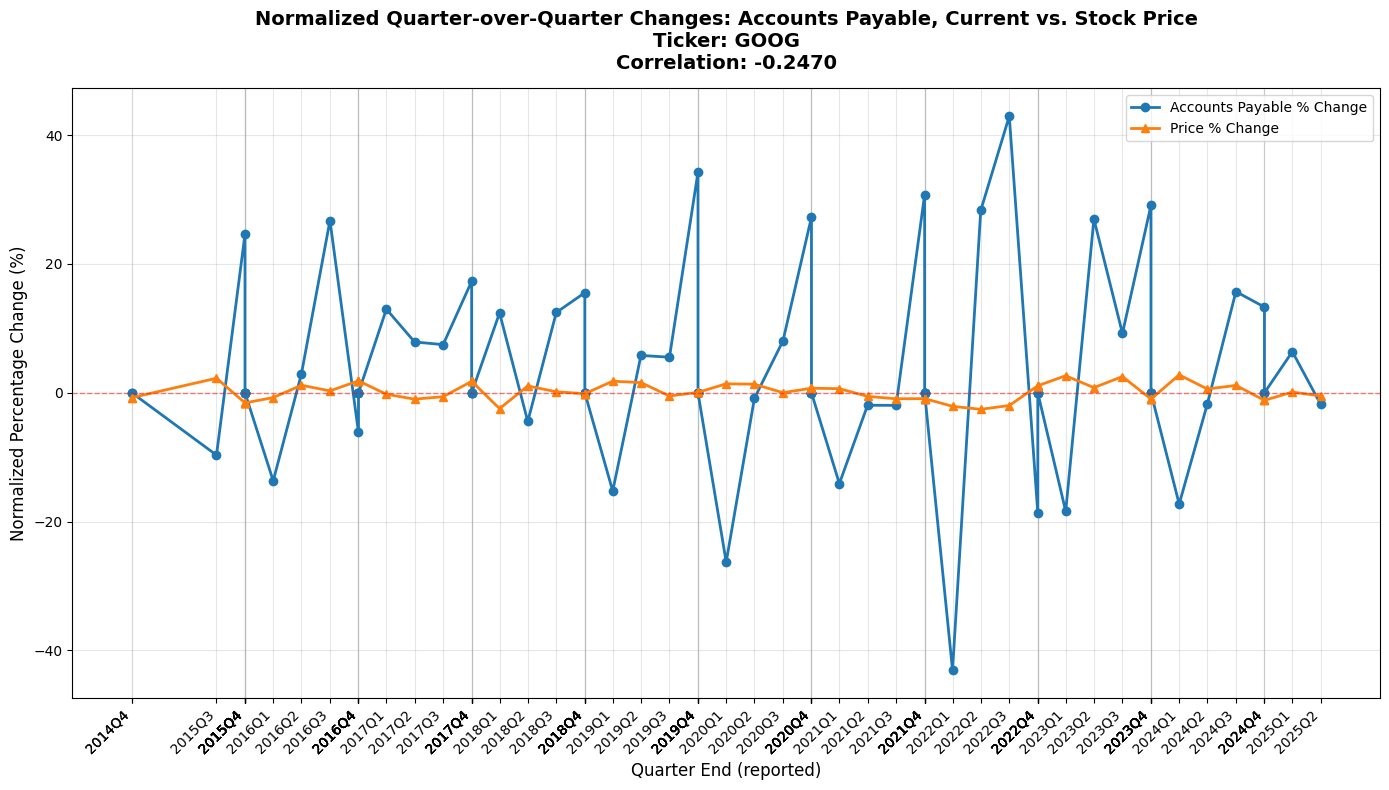


Total quarters plotted: 81
Quarter range: 2014Q4 to 2025Q2
Quarter end date range: 2014-12-31 to 2025-06-30


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(example['label'].unique())

# Define variables
y1_label = 'Accounts Payable, Current'
y2 = 'value % before'
y3 = 'Price after % change'
FILTER_TICKER = 'GOOG'

df = example.copy()

if 'end_date' not in df.columns:
    raise KeyError("DataFrame must have an 'end_date' column to derive actual reported quarters.")
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Derive reported quarters (e.g., 2021Q4)
df['reported_quarter'] = df['end_date'].dt.to_period('Q')

# Set quarter end date for plotting
df['quarter_end'] = df['reported_quarter'].dt.to_timestamp(how='end')

# Filter for Google and Accounts Payable, Current
plot_data = df[(df['Ticker'] == FILTER_TICKER) & (df['label'] == y1_label)].copy()

# Drop rows with missing values in the columns to plot
plot_data = plot_data.dropna(subset=[y2, y3, 'quarter_end'])

# Sort by quarter for proper plotting
plot_data['__q_ordinal'] = plot_data['reported_quarter'].apply(lambda p: p.ordinal)
plot_data = plot_data.sort_values('__q_ordinal').reset_index(drop=True)

# Calculate correlation
correlation = plot_data[[y2, y3]].corr().iloc[0, 1]
print(f"\nCorrelation between {y2} and {y3} for {FILTER_TICKER}: {correlation:.4f}")

# Create the line plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot percentage change in Accounts Payable, Current
ax.plot(plot_data['quarter_end'], plot_data[y2], marker='o', linewidth=2, markersize=6, label='Accounts Payable % Change')
# Plot percentage change in stock price
ax.plot(plot_data['quarter_end'], plot_data[y3], marker='^', linewidth=2, markersize=6, label='Price % Change')

# Add horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Customize plot
ax.set_xlabel('Quarter End (reported)', fontsize=12)
ax.set_ylabel('Normalized Percentage Change (%)', fontsize=12)
ax.set_title(f'Normalized Quarter-over-Quarter Changes: {y1_label} vs. Stock Price\nTicker: {FILTER_TICKER}\nCorrelation: {correlation:.4f}', fontsize=14, fontweight='bold', pad=14)

ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)

# Set x-axis labels to quarters
x_labels = [str(p) for p in plot_data['reported_quarter']]
ax.set_xticks(plot_data['quarter_end'])
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Adjust layout and display
fig.tight_layout()
plt.show()


***